### 1. Develop a DMD model to forecast the future population states

#### Load libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

# ! mkdir plots

import warnings
warnings.filterwarnings('ignore')

#### Load data

In [2]:
df = pd.read_csv('data/table.csv')
df = df.set_index(['year'])
df.head()

,hare,lynx
year,,
1845,20,32
1847,20,50
1849,52,12
1851,83,10
1853,64,13


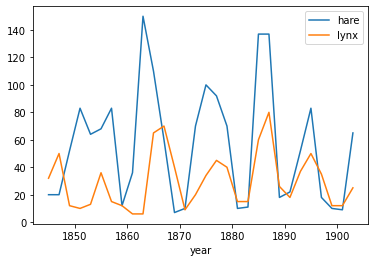

In [3]:
df.plot()

#### Interpolate

In [4]:
def densify(t,y,dt):
    
    f = interp1d(t, y, kind='cubic')
    
    tnew = np.arange(t[0], t[-1], dt)
    ynew = f(tnew)
    return tnew, ynew

In [5]:
years = df.index.values
x1    = df['hare'].values
x2    = df['lynx'].values

In [6]:
dt = 0.1
t, x1 = densify(years,x1, dt)
t, x2 = densify(years,x2, dt)

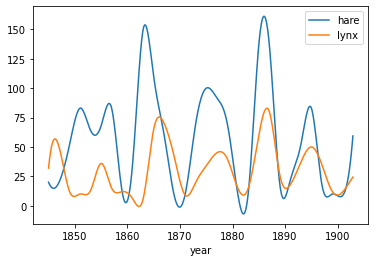

In [7]:
df_new = pd.DataFrame({'year':t, 'hare':x1, 'lynx':x2}).set_index(['year'])
df_new.plot();

In [8]:
x = np.vstack([x1,x2])
x = x.T
x.shape

(580, 2)

#### Prepare inputs for DMD

In [9]:
r   = 2
X1  = x[:-1].T
X2  = x[1:].T

#### Define DMD function 

In [10]:
def DMD(X,Xprime,r):
    
    # Step 1
    U,Sigma,VT = np.linalg.svd(X,full_matrices=0) 
    Ur = U[:,:r]
    Sigmar = np.diag(Sigma[:r])
    VTr = VT[:r,:]
    
    # Step 2
    Atilde = np.linalg.solve(Sigmar.T,(Ur.T @ Xprime @ VTr.T).T).T 
    
    # Step 3
    Lambda, W = np.linalg.eig(Atilde) 
    Lambda = np.diag(Lambda)
    
    # Step 4
    Phi = Xprime @ np.linalg.solve(Sigmar.T,VTr).T @ W 
    alpha1 = Sigmar @ VTr[:,0]
    
    b = np.linalg.solve(W @ Lambda,alpha1)
    
    return Phi, Lambda, b

#### Run DMD and forecast

In [11]:
Phi, Lambda, b = DMD(X1,X2,r)

In [12]:
omega = np.log(np.diag(Lambda))/dt

In [13]:
forecast = []

for i in np.arange(0,58,dt):
    c = Phi @ np.diag(np.exp(omega*i)) @ b.T
    forecast.append(c.flatten())
forecast = np.array(forecast)

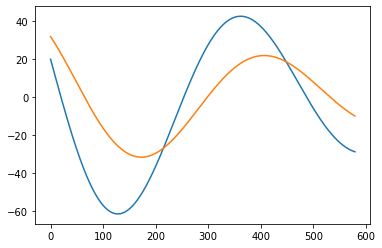

In [14]:
plt.plot(forecast);

#### Compare with original data

In [15]:
df_new['hare_prediction']  = forecast[:,0]
df_new['lynx_prediction']  = forecast[:,1]

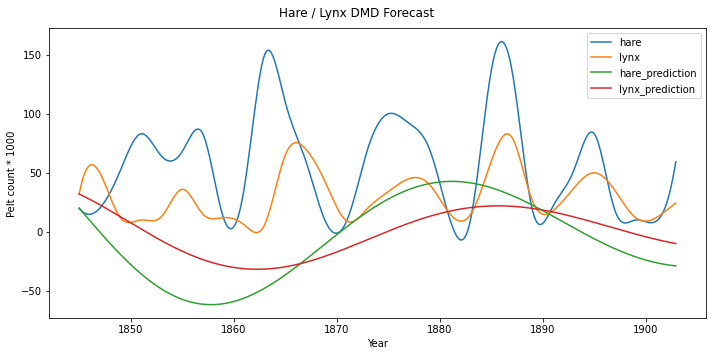

In [16]:
plt.figure(figsize=(10, 5))
ax = plt.subplot(1,1,1)
df_new.plot(ax=ax)
plt.suptitle('Hare / Lynx DMD Forecast')
plt.xlabel('Year')
plt.ylabel('Pelt count * 1000')
plt.tight_layout()
plt.subplots_adjust(top=0.92)

# plt.savefig('plots/Q1_fig1.png')

### 2. Do a time-delay DMD model to produce a forecast and compare with regular DMD. Determine if it is likely that there are latent variables.

#### Prepare interpolated data

In [17]:
years = df.index.values
x1    = df['hare'].values
x2    = df['lynx'].values

In [18]:
dt = 0.1
t, x1 = densify(years,x1, dt)
t, x2 = densify(years,x2, dt)
x = np.vstack([x1,x2])
x = x.T
x.shape

(580, 2)

#### Create Hankel matrix

In [19]:
from scipy.linalg import hankel
H = hankel(x)

# x1 = hankel(x1)
# x2 = hankel(x2)
# H = np.vstack([x1,x2])

In [20]:
H.shape

(1160, 1160)

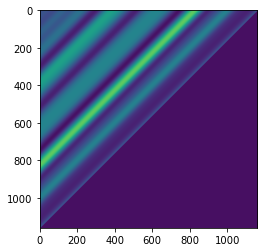

In [21]:
plt.imshow(H);

### Examine variance explained by each mode

In [22]:
U,Sigma,VT = np.linalg.svd(H,full_matrices=0)

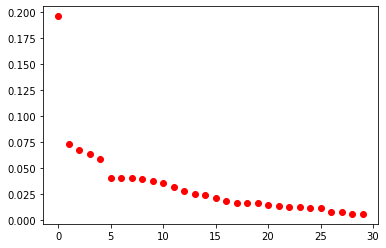

In [23]:
Sigma = Sigma[:30]
plt.plot(np.diag(np.diag(Sigma)/np.sum(np.diag(Sigma))), 'ro');

#### Prepare inputs for DMD

In [24]:
X1 = H[:-1].T
X2 = H[1:].T

In [25]:
X2.shape

(1160, 1159)

#### Forecast

In [26]:
r = 30
Phi, Lambda, b = DMD(X1,X2,r)

In [27]:
Phi.shape, Lambda.shape, b.shape

((1160, 30), (30, 30), (30,))

In [28]:
omega = np.log(np.diag(Lambda))/dt

In [29]:
forecast = []

for i in np.arange(0,116,.1):
    c = Phi @ np.diag(np.exp(omega*i)) @ b.T
    forecast.append(c.flatten())
forecast = np.array(forecast)

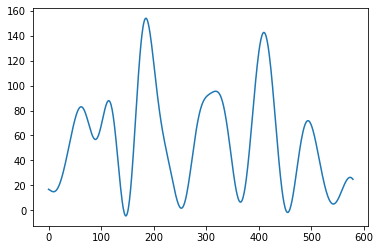

In [30]:
plt.plot(forecast.T[0][0::2]);

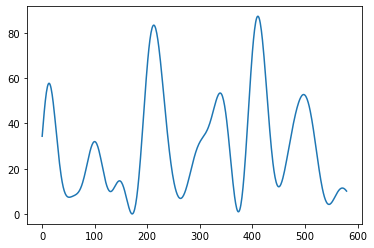

In [31]:
plt.plot(forecast.T[0][1::2]);

In [32]:
df_new = pd.DataFrame({'year':t, 'hare':x1, 'lynx':x2}).set_index(['year'])
df_new['hare_prediction']  = forecast.T[0][0::2]
df_new['lynx_prediction']  = forecast.T[0][1::2]

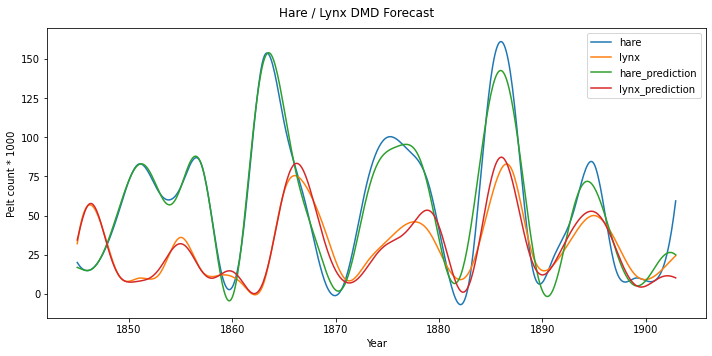

In [33]:
plt.figure(figsize=(10, 5))
ax = plt.subplot(1,1,1)
df_new.plot(ax=ax)
plt.suptitle('Hare / Lynx DMD Forecast')
plt.xlabel('Year')
plt.ylabel('Pelt count * 1000')
plt.tight_layout()
plt.subplots_adjust(top=0.92)

# plt.savefig('plots/Q1_fig1.png')

### 3. Empirical Predator-Prey models such as Lotka-Volterra are commonly used to model such phenomenon. Consider the model x ̇ = (b − py)x and y ̇ = (rx − d)y. Use the data to fit values of b, p, r and d.

#### Define function

In [34]:
def lotkavolterra(t, x0, b, p, d, r):
    x, y = x0
    return [b*x - p*x*y, -d*y + r*x*y]

#### Interpolate time series

In [35]:
years = df.index.values
x1    = df['hare'].values
x2    = df['lynx'].values

dt = 0.2
t, x1 = densify(years,x1, dt)
t, x2 = densify(years,x2, dt)

#### Plot initial dense data

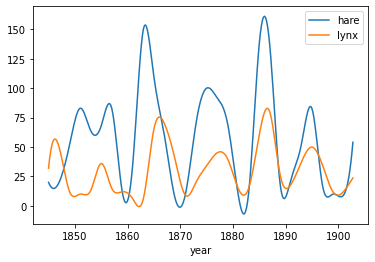

In [36]:
df_new = pd.DataFrame({'year':t, 'hare':x1, 'lynx':x2}).set_index(['year'])
df_new.plot();

#### Set up SINDy to get initial guess

In [37]:
def SINDy(x1s, x2s, Ax1s, Ax2s, dt):
    # compute derivative
    n = len(t)
    x1dots = []
    x2dots = []
    for j in range(1,n-1):
        x1dot = (x1[j+1] - x1[j-1]) / (2*dt) 
        x2dot = (x2[j+1] - x2[j-1]) / (2*dt)
        x1dots.append(x1dot)
        x2dots.append(x2dot)
    x1dots = np.array(x1dots)
    x2dots = np.array(x2dots)

    # run linear regression to find coefficients
    clf1 = linear_model.Lasso(alpha=0.001)
    clf1.fit(Ax1s.T, x1dots)
    clf2 = linear_model.Lasso(alpha=0.001)
    clf2.fit(Ax2s.T, x2dots)

    return clf1.coef_, clf2.coef_

#### Create matrix A from inner time series for each term

In [38]:
x1s = x1[1:-1]
x2s = x2[1:-1]
Ax1s = np.array([x1s, x1s*x2s])
Ax2s = np.array([x2s, x1s*x2s])

In [39]:
x1s = x1[1:-1]
x2s = x2[1:-1]
Ax1s = np.array([x1s, 
                 x1s*x2s])
                
Ax2s = np.array([x2s, 
                 x1s*x2s])

#### Run SINDy

In [40]:
clf1_coef, clf2_coef = SINDy(x1s, x2s, Ax1s, Ax2s, dt)

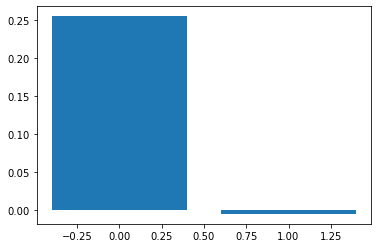

In [41]:
plt.bar(np.arange(len(clf1_coef)), clf1_coef);

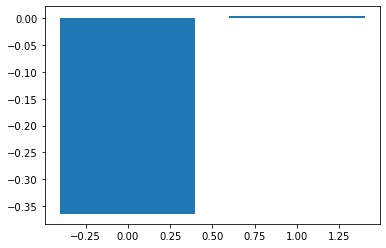

In [42]:
plt.bar(np.arange(len(clf2_coef)), clf2_coef);

#### Pull out coefficients

In [43]:
b, p, d, r = np.abs((clf1_coef[0], clf1_coef[1], clf2_coef[0], clf2_coef[1]))
b, p, d, r

(0.25537416681302194,
 0.005496395045871686,
 0.36435281521610596,
 0.003433344270585564)

#### Make prediction

In [44]:
t_range = [0, len(t)]
x0 = (x1[0], x2[0])
sol = solve_ivp(lotkavolterra, t_range, x0, args=(b, p, d, r), dense_output=True)

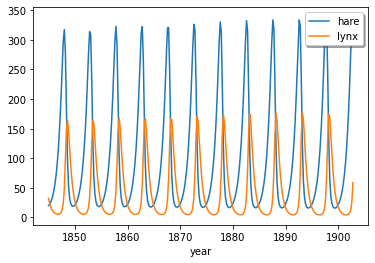

In [45]:
t = np.arange(0, len(t), 1)
pred_sindy_derived = sol.sol(t)

x = np.arange(years[0], years[-1], dt)
plt.plot(x, pred_sindy_derived.T)
plt.xlabel('year')
plt.legend(['hare', 'lynx'], shadow=True)
plt.show()

#### Compare with original

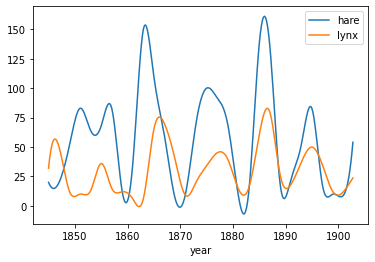

In [46]:
df_new.plot();

#### Best approximation after trial and error

In [47]:
b, p, d, r = 0.14, 0.005, 0.2, 0.0034 # best approximation after trial and error
b, p, d, r

(0.14, 0.005, 0.2, 0.0034)

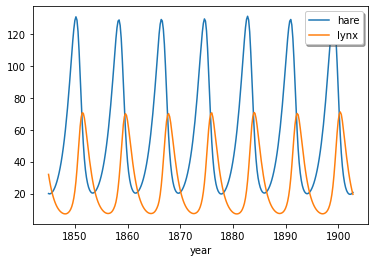

In [48]:
t_range = [0, len(t)]
x0 = (x1[0], x2[0])
sol = solve_ivp(lotkavolterra, t_range, x0, args=(b, p, d, r), dense_output=True)

t = np.arange(0, len(t), 1)
pred_estimated = sol.sol(t)

x = np.arange(years[0], years[-1], dt)
plt.plot(x, pred_estimated.T)
plt.xlabel('year')
plt.legend(['hare', 'lynx'], shadow=True)
plt.show()

#### Compare to original

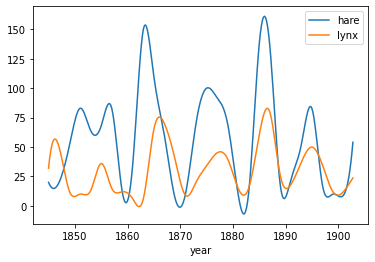

In [49]:
df_new.plot();

### 4. Find the best fit nonlinear, dynamical systems model to the data using sparse regression.

In [50]:
def lotkavolterra(t, x0, a):
    x, y = x0
    return [np.cos(t*.019) + np.sin(t*.06), np.cos(t*.04) - np.sin(t*.045)]

In [51]:
a = 2

In [52]:
t_range = [0, len(t)]
x0 = (x1[0], x2[0])
sol = solve_ivp(lotkavolterra, t_range, x0, args=(a,), dense_output=True)

In [53]:
clf1_coef, clf2_coef

(array([ 0.25537417, -0.0054964 ]), array([-0.36435282,  0.00343334]))

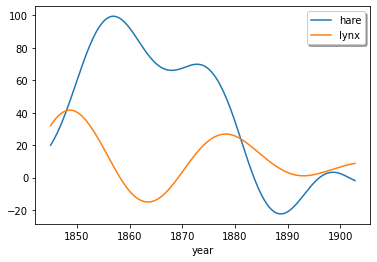

In [54]:
t = np.arange(0, len(t), 1)
pred_sindy_derived = sol.sol(t)

x = np.arange(years[0], years[-1], dt)
plt.plot(x, pred_sindy_derived.T)
plt.xlabel('year')
plt.legend(['hare', 'lynx'], shadow=True)
plt.show()

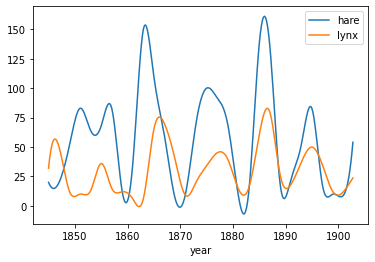

In [55]:
df_new.plot();

#### Create matrix A with non linear terms

In [56]:
x1s = x1[1:-1]
x2s = x2[1:-1]
Ax1s = np.array([x1s, x1s*x2s, np.cos(x1s), np.sin(x1s)])
Ax2s = np.array([x2s, x1s*x2s, np.cos(x2s), np.sin(x2s)])

#### Run SINDy

In [57]:
clf1_coef, clf2_coef = SINDy(x1s, x2s, Ax1s, Ax2s, dt)

In [58]:
clf1_coef, clf2_coef

(array([ 0.25771163, -0.00554362,  2.67480373,  3.80204783]),
 array([-0.35330284,  0.00338429, -1.14799686,  0.93526128]))

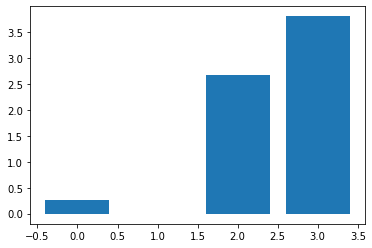

In [59]:
plt.bar(np.arange(len(clf1_coef)), clf1_coef);

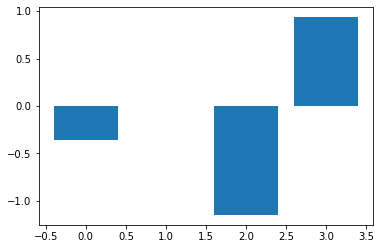

In [60]:
plt.bar(np.arange(len(clf2_coef)), clf2_coef);

#### Pull out coefficients

In [61]:
a,b,c,d = np.abs((clf1_coef[0], clf1_coef[1], clf1_coef[2], clf1_coef[3]))
e,f,g,h = np.abs((clf2_coef[0], clf2_coef[1], clf2_coef[2], clf2_coef[3]))

In [62]:
def lotkavolterra(t, x0, a,b,c,d, e,f,g,h):
    x, y = x0
    return [c*np.cos(x), h*np.sin(y)]

#### Make prediction

In [63]:
t_range = [0, len(t)]
x0 = (x1[0], x2[0])
sol = solve_ivp(lotkavolterra, t_range, x0, args=(a,b,c,d, e,f,g,h), dense_output=True)

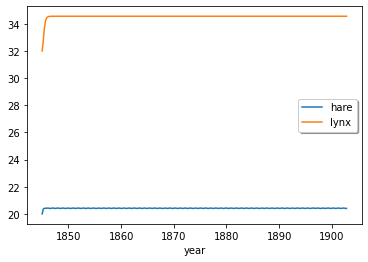

In [64]:
t = np.arange(0, len(t), 1)
pred_sindy_derived = sol.sol(t)

x = np.arange(years[0], years[-1], dt)
plt.plot(x, pred_sindy_derived.T)
plt.xlabel('year')
plt.legend(['hare', 'lynx'], shadow=True)
plt.show()

#### Compare with original

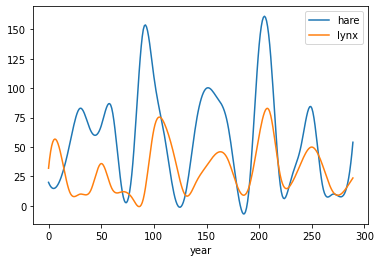

In [65]:
df_new = pd.DataFrame({'year':t, 'hare':x1, 'lynx':x2}).set_index(['year'])
df_new.plot();

### 5. Compute the KL divergence of the best model fit to the data between all the above models.

In [66]:
# adapted from https://gist.github.com/swayson/86c296aa354a555536e6765bbe726ff7
def kl(p, q):
    z = p * np.log(p / q)
    z = z[~np.isnan(z)]
    return np.sum(z)

In [67]:
p = pred_sindy_derived[0]
q = df_new.hare.values
kl(p, q)

-3781.388450842135

In [68]:
p = pred_sindy_derived[1]
q = df_new.lynx.values
kl(p, q)

3744.8889717734373

In [69]:
p = pred_estimated[0]
q = df_new.hare.values
kl(p, q)

10656.101067533062

In [70]:
p = pred_estimated[1]
q = df_new.lynx.values
kl(p, q)

3796.3312693234625

### 6. Retain three of your best fit models and compare their AIC and BIC scores.

In [71]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

regr = OLS(pred_sindy_derived[0], add_constant(df_new.hare.values)).fit()
print(regr.bic)
print(regr.aic)

-1258.9863008700356
-1266.3260627159966


In [72]:
regr = OLS(pred_sindy_derived[1], add_constant(df_new.lynx.values)).fit()
print(regr.bic)
print(regr.aic)

-118.74494191389438
-126.08470375985542


In [73]:
regr = OLS(pred_estimated[0], add_constant(df_new.hare.values)).fit()
print(regr.bic)
print(regr.aic)

2921.9754406840934
2914.635678838132


In [74]:
regr = OLS(pred_estimated[1], add_constant(df_new.lynx.values)).fit()
print(regr.bic)
print(regr.aic)

2600.326446434443
2592.9866845884817


### Download the data set BZ.mat (which is a snipet from a Belousov-Zhabotinsky chemical oscillator movie – check them out on youtube).


#### 1. get the data: download from the course website (It is next to HW 2)
#### 2. See what you can do with the data (i.e. repeat the first two steps above)   

In [75]:
import h5py
import numpy as np
import matplotlib.animation as animation

#### Import and examine data

In [76]:
f = h5py.File('./data/BZ.mat','r')
data = f.get('BZ_tensor')
data = np.array(data)

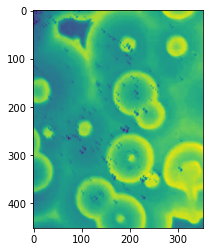

In [77]:
plt.imshow(data[0])

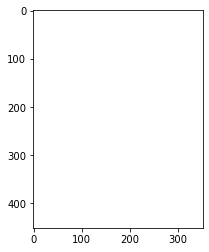

In [78]:
fig = plt.figure()
ims = []
for i in data:
    im = plt.imshow(i, animated=True)
    ims.append([im])
ani = animation.ArtistAnimation(fig, ims)
# ani.save('data/movie_full.mp4')

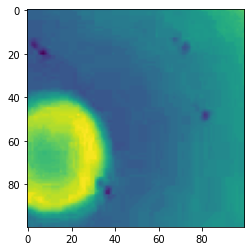

In [79]:
plt.imshow(data[0][100:200,0:100])

In [80]:
print('Frames:', len(data))
print('Movie duration: 4:00 min')
print('Frames per minute:', 300)

Frames: 1200
Movie duration: 4:00 min
Frames per minute: 300


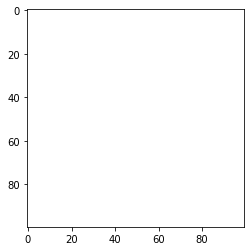

In [81]:
fig = plt.figure()
ims = []
for i in range(300):
    im = plt.imshow(data[i][100:200,0:100], animated=True)
    ims.append([im])
ani = animation.ArtistAnimation(fig, ims)
# ani.save('data/movie_sub.mp4')

#### Prepare data

In [82]:
data_sub = []
for i in range(300):
    frame = data[i][100:200,0:100]
    data_sub.append(frame)
data_sub = np.array(data_sub)

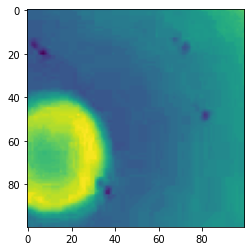

In [83]:
plt.imshow(data_sub[0]);

In [84]:
data_sub.shape

(300, 100, 100)

In [85]:
data.shape

(1200, 451, 351)

In [86]:
X = []
for i in data_sub:
    X.append(i.flatten())
    
X = np.array(X)

In [87]:
X.shape

(300, 10000)

In [88]:
r = 10
X1 = X[0:-1].T
X2 = X[1:].T

In [89]:
Phi, Lambda, b = DMD(X1,X2,r)

In [90]:
omega = np.log(np.diag(Lambda))/dt

In [91]:
forecast = []

for i in np.arange(0,100,dt):
    c = Phi @ np.diag(np.exp(omega*i)) @ b.T
    forecast.append(c.flatten())
forecast = np.array(forecast)

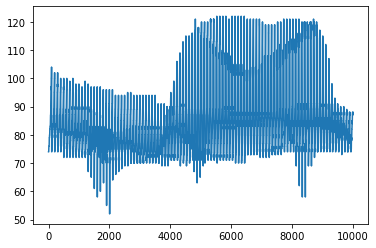

In [92]:
plt.plot(X1.T[0])

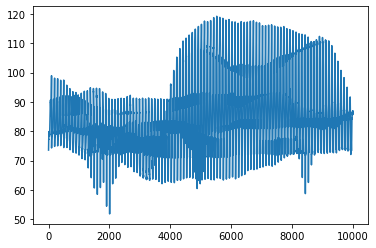

In [93]:
plt.plot(forecast[0])

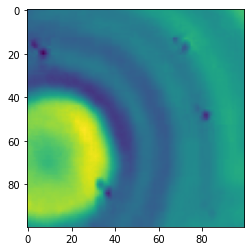

In [94]:
plt.imshow(forecast[0].real.reshape(100,100))

In [95]:
reconstructed_data = []

for i in range(len(forecast)):
    im = forecast[i].real.reshape(100,100)
    reconstructed_data.append(im)

reconstructed_data = np.array(reconstructed_data)

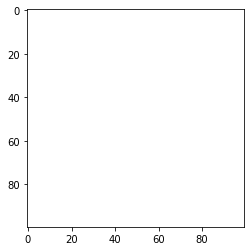

In [96]:
fig = plt.figure()
ims = []
for i in reconstructed_data:
    im = plt.imshow(i, animated=True)
    ims.append([im])
ani = animation.ArtistAnimation(fig, ims)
# ani.save('data/movie_sub_reconstructed.mp4')

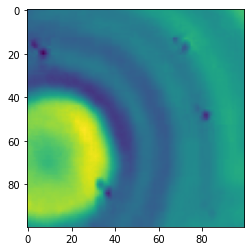

In [97]:
plt.imshow(reconstructed_data[0])